I'm currently following a class on signal processing applied to audio on Coursera. It's awesome and I learned quite a number of things in it. In particular, I realized how important analysis windows are when working with sounds. This post will detail the properties in terms of main lobe size and side lobe level for commonly used windows, such as the rectangular (boxcar), hanning, hamming or blackman windows.


This post is organized as follows:

- using a hamming window, we go through the details of computing mainlobe width and sidelobe levels
- we then do this calculation and graphical representation common windows
- finally, we try to gain intuition of mainlobe width versus sidelobe level using concrete examples of signal analysis: 
    - a single sinuisoid (using different windows)
    - analyzing two sinusoids with close frequencies 
    - analyzing two sinuisoids with different frequencies and very different amplitudes

# Window properties with a hamming window 

First, let's do some imports.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set() # styling

Our first step in this post is to define a "time" vector, with which we will define the hamming window we want to analyze.

In [2]:
m = 513
t = np.arange(m)

Using this time vector, we can define our window signal `w` using SciPy's `get_window` function (found in the `scipy.signal` module).

In [3]:
from scipy.signal import get_window

w = get_window('hamming', m)

We can plot this window:

(-0.025, 1.025)

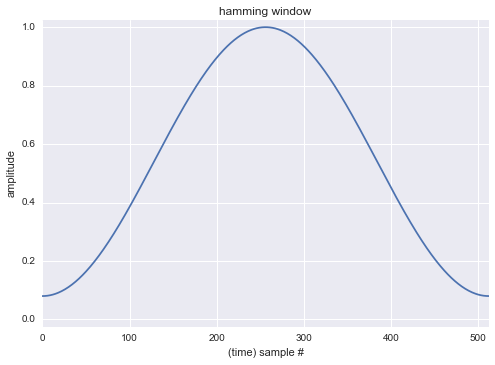

In [4]:
plt.plot(t, w)
plt.xlabel("(time) sample #")
plt.ylabel("amplitude")
plt.title("hamming window")
plt.xlim(0, m-1)
plt.ylim(-0.025, 1.025)

We recognize the typical hamming window characteristic: it's tapered on both sides by a nonzero value.

Let's now perform the FFT of this window. The signal is real, so we use the Fourier transform tools for real valued signals in the following analysis (`rfft` instead of `fft` for instance).

In [5]:
w_fft = np.fft.rfft(w)

We can plot the spectrum of the window (we ignore the phase and just plot its magnitude).

In [6]:
freqs = np.fft.rfftfreq(w.size, d=1/m)

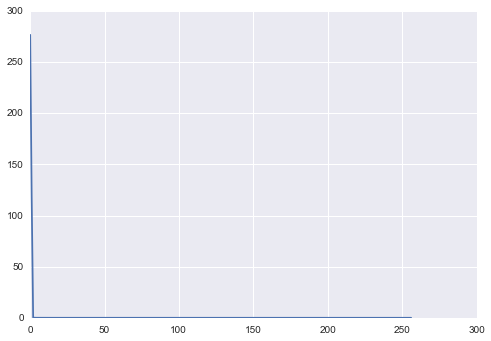

In [7]:
plt.plot(freqs, np.abs(w_fft))

Actually, we need to zoom this representation to be able to make sense of it.

(0, 20)

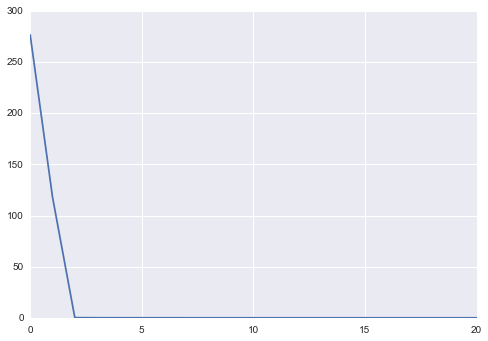

In [8]:
plt.plot(freqs, np.abs(w_fft))
plt.xlim(0, 20)

Clearly, we don't see a lot of things here. Fortunately, we can interpolate the spectrum by doing zero padding. The idea here is that this doesn't change the spectrum itself, it just computes more points of it, which makes it appear very smooth.

(0, 20)

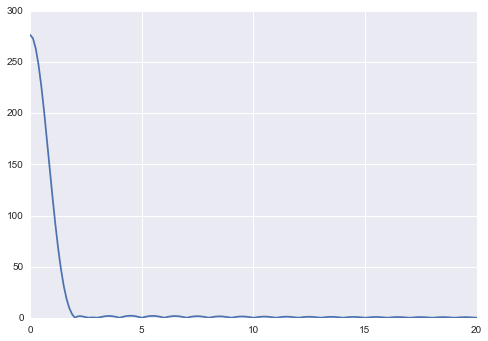

In [9]:
n = 4096
w_fft = np.fft.rfft(w, n=4096)
freqs = np.fft.rfftfreq(n, d=1/m)
plt.plot(freqs, np.abs(w_fft))
plt.xlim(0, 20)

In fact, it's even better to represent the previous plot using decibels on the vertical axis, as this is the commonly used unit in signal processing.

(0, 20)

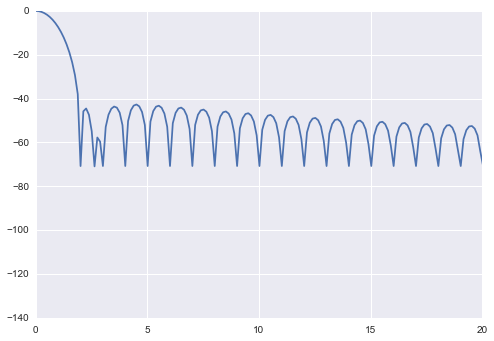

In [10]:
plt.plot(freqs, 20*np.log10(np.abs(w_fft) / np.abs(w_fft).max()))
plt.xlim(0, 20)

Using this figure, we can appreciate the two main properties of filtering windows:

- the main lobe width, which is the location where the mainlobe ends and "dives down the y-axis" the first time when starting from 0
- side lobe level, which is the height of the oscillations that appear at the right of the mainlobe (here around -40 dB)

The main lobe width will allow us to determine the spectral resolution of the signal we are analyzing. The sidelobes are "noise" that gets added to all frequency components and can hide other spectral peaks present. They are important when analyzing a signal with lots of peaks with different magnitudes.

Let's now write a little bit of code to computes these two properties from the Fourier spectrum.

In [11]:
def compute_mainlobe_width(spectrum):
    """
    computes mainlobe width from spectrum
    
    assumes the mainlobe starts at 0, that spectrum size is odd, and that 
    the spectrum is real-valued (half of the frequencies)
    
    returns the number of samples of full mainlobe (not just half)
    """
    abs_spectrum = np.abs(spectrum)
    current_value = abs_spectrum[0]
    for ind, next_value in enumerate(abs_spectrum):
        if next_value > current_value:
            break
        else:
            current_value = next_value        
    return 2 * ind - 1

Let's test this on the previously computed spectrum.

In [12]:
compute_mainlobe_width(w_fft)

33

Let's look at the first $(33 - 1) / 2 + 1= 17$  samples of the spectrum to see if they end on a local minimum:

In [13]:
np.abs(w_fft)[:17]

array([  2.76560000e+02,   2.73145445e+02,   2.63112161e+02,
         2.47073148e+02,   2.25991449e+02,   2.01098528e+02,
         1.73791853e+02,   1.45521952e+02,   1.17680000e+02,
         9.14966227e+01,   6.79610733e+01,   4.77674316e+01,
         3.12913805e+01,   1.85977221e+01,   9.47556072e+00,
         3.49534175e+00,   8.00000000e-02])

In [14]:
np.abs(w_fft)[17]

1.4184820846613027

So indeed, our mainlobe computation works.

Let's now move on to sidelobes. Using the mainlobe computation, we can quite simply take the maximum value outside of the mainlobe as the sidelobe level.

In [15]:
def compute_sidelobe_level(spectrum):
    """
    computes sidelobe level from spectrum

    assumes the mainlobe starts at 0, that spectrum size is odd, and that 
    the spectrum is real-valued (half of the frequencies)
    
    returns the level of sidelobes in dB 
    """
    mainlobe_width = compute_mainlobe_width(spectrum)
    
    ind = (mainlobe_width - 1) / 2
    
    abs_spectrum = np.abs(spectrum)
    
    return 20 * np.log10(abs_spectrum[ind:].max() / abs_spectrum.max())
    

Let's use this function on the previous spectrum. From the above plot, we expect the result to be a bit below -40 dB. 

In [16]:
compute_sidelobe_level(w_fft)

-42.680923568006968

We can now complete the previous plot with lines to outline mainlobe width and sidelobe level:

/Users/kappamaki/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


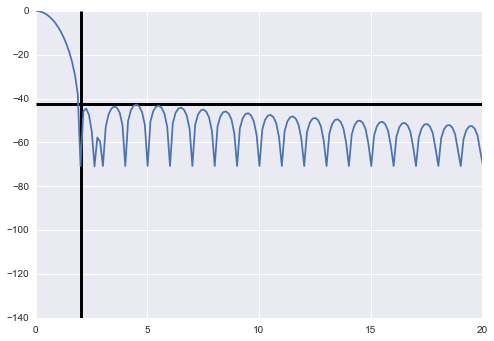

In [17]:
plt.plot(freqs, 20*np.log10(np.abs(w_fft) / np.abs(w_fft).max()))
plt.xlim(0, 20)
width = compute_mainlobe_width(w_fft)
level = compute_sidelobe_level(w_fft)

ylim_range = plt.ylim()
plt.vlines((width - 1) / 2 * m / n, ylim_range[0], ylim_range[1], lw=3)
xlim_range = plt.xlim()
plt.hlines(level, xlim_range[0], xlim_range[1], lw=3)

With these functions in place, we can now perform this analysis for several windows

# Properties of common windows 

Below, we reuse the code we have just developed and appy it to several common windows.

/Users/kappamaki/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


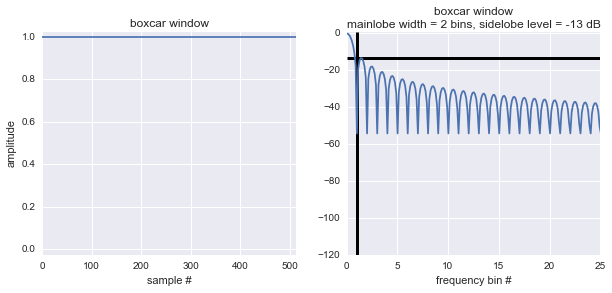

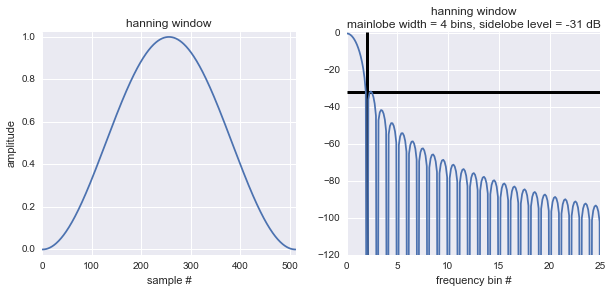

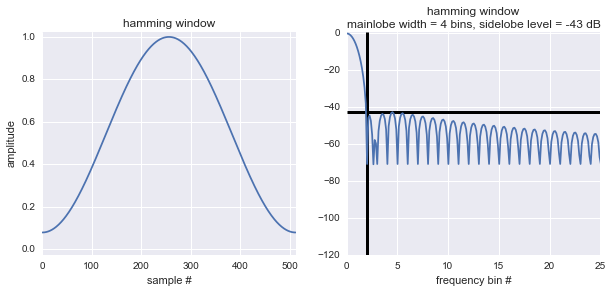

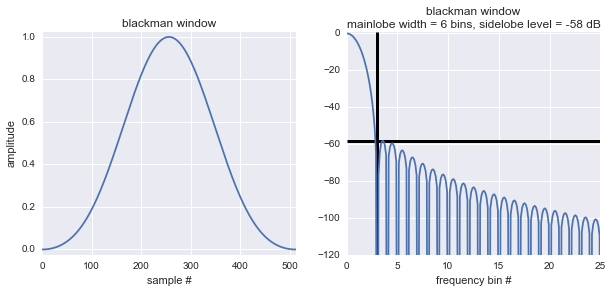

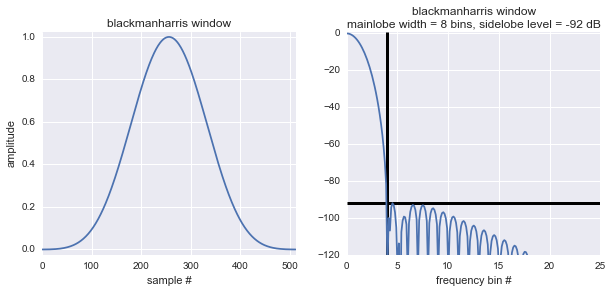

In [18]:
for window in ['boxcar', 'hanning', 'hamming', 'blackman', 'blackmanharris']:
    m = 513
    w = get_window(window, m)
    n = 4096
    w_fft = np.fft.rfft(w, n)
    freqs = np.fft.rfftfreq(n, d=1/m)
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.plot(t, w)
    plt.xlabel("sample #")
    plt.ylabel("amplitude")
    plt.title("{} window".format(window))
    plt.xlim(0, t.size)
    plt.ylim(-0.025, 1.025)
    plt.subplot(122)
    plt.plot(freqs, 20*np.log10(np.abs(w_fft) / np.abs(w_fft).max()))
    plt.xlim(0, 25)
    plt.ylim(-120, 1)
    width = compute_mainlobe_width(w_fft)
    width_bins = width * m / n
    level = compute_sidelobe_level(w_fft)
    ylim_range = plt.ylim()
    plt.vlines((width - 1) / 2 * m / n, ylim_range[0], ylim_range[1], lw=3)
    xlim_range = plt.xlim()
    plt.hlines(level, xlim_range[0], xlim_range[1], lw=3)
    plt.title("{} window\nmainlobe width = {:.0f} bins, sidelobe level = {:.0f} dB".format(window,
                                                                       width_bins, 
                                                                       level))
    plt.xlabel('frequency bin #')

We can put this information within a dataframe to display it in a nicer way:

In [19]:
import pandas as pd

In [20]:
props = {}
for window in ['boxcar', 'hanning', 'hamming', 'blackman', 'blackmanharris']:
    m = 513
    w = get_window(window, m)
    n = 4096
    w_fft = np.fft.rfft(w, n)
    freqs = np.fft.rfftfreq(n, d=1/m)
    width = compute_mainlobe_width(w_fft)
    width_bins = width * m / n
    level = compute_sidelobe_level(w_fft)
    props[window] = {'mainlobe width (bins)': width_bins,
                    'sidelobe level (dB)': level}
df = pd.DataFrame(props).transpose()
df

,mainlobe width (bins),sidelobe level (dB)
blackman,6.136963,-58.238288
blackmanharris,8.140869,-92.034821
boxcar,2.129150,-13.383597
hamming,4.133057,-42.680924
hanning,4.133057,-31.475492


We can sort the windows by increasing mainlobe width:

In [21]:
df.sort(columns='mainlobe width (bins)', inplace=False)

/Users/kappamaki/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,mainlobe width (bins),sidelobe level (dB)
boxcar,2.129150,-13.383597
hamming,4.133057,-42.680924
hanning,4.133057,-31.475492
blackman,6.136963,-58.238288
blackmanharris,8.140869,-92.034821


Or by increasing sidelobe level.

In [22]:
df.sort(columns='sidelobe level (dB)', inplace=False)

/Users/kappamaki/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,mainlobe width (bins),sidelobe level (dB)
blackmanharris,8.140869,-92.034821
blackman,6.136963,-58.238288
hamming,4.133057,-42.680924
hanning,4.133057,-31.475492
boxcar,2.129150,-13.383597


This makes it clearly apparent that mainlobe width and sidelobe levels are in fact a compromise. Either a window permits clear positioning of peaks, or it allows identification of peaks with large amplitude variations. In the next section, we apply this to spectral analysis problems.

# Examples of signal analysis

## A single sinusoid 

As a first step, we'll look at the effect of different windows on the Fourier transform of a single sinusoid. Let's generate our sample data and look at it.

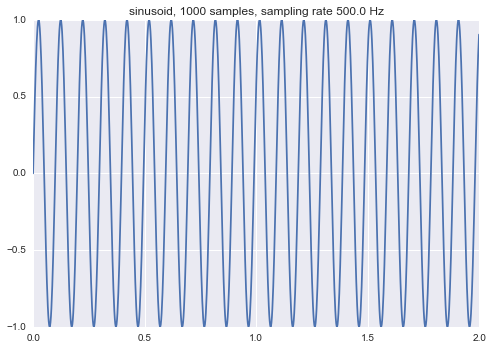

In [23]:
t = np.arange(0, 2, step=1/500)
m = t.size
s = np.sin(2 * np.pi * 10.1 * t)
plt.plot(t, s)
plt.title("sinusoid, {} samples, sampling rate {} Hz".format(m, 1/(t[1] - t[0])))

We now perform the FFT with several windows and plot its magnitude.

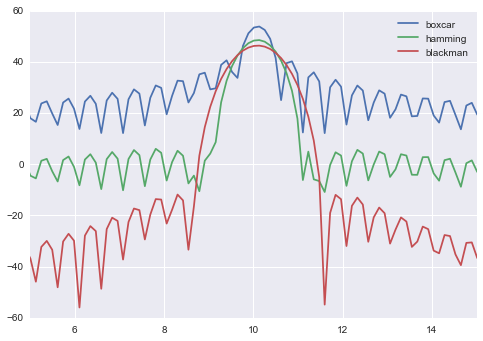

In [24]:
for window in ['boxcar', 'hamming', 'blackman']:
    n = 4096
    w = np.fft.rfft(s * get_window(window, m), n=n)
    freqs = np.fft.rfftfreq(n, d=t[1] - t[0])
    plt.plot(freqs, 20*np.log10(np.abs(w)), label=window)
plt.ylim(-60, 60)
plt.xlim(5, 15)
plt.legend()

This plot illustrates the fact that the Fourier transform of a windowed sinusoid is obtained by shifting the Fourier transform of the window used in the time domain to the frequency of the sinusoid.

Depending on the window used, we clearly see the compromise between narrow mainlobes and low sidelobes in this plot.

The mainlobe widths computed in the previous section allow us to size the frequency bandwidth over which the Fourier transform of the sinusoid will stretch, using the following formula:

$$
\Delta f = \text{window_mainlobe_bins} \frac{\text{sampling_rate}}{\text{original_signal_samples}}
$$

In our case:

- boxcar: 2 * 500 / 1000 = 1 Hz
- hamming: 4 * 500 / 1000  = 2 Hz
- blackman: 8 * 500 / 1000 = 4 Hz

This formula allows for accurate sizing in case of interferences with two close frequencies as can be seen in the next paragraph.

##  Two sinusoids with close frequencies

In this problem, we're looking at the problem of estimating the frequencies of two sinusoids that have close frequencies. 

First, let's generate our sample data and look at it.

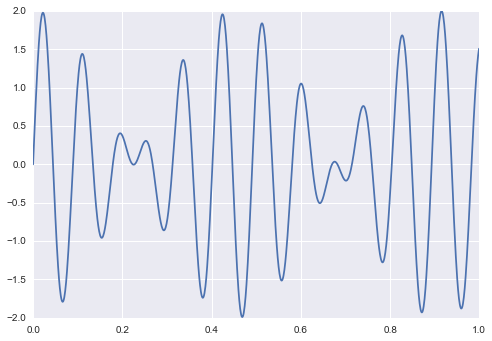

In [25]:
t = np.arange(0, 1, step=1/1000.)
m = t.size
s = np.sin(2 * np.pi * 10.1 * t) + np.sin(2 * np.pi * 12.3 * t)
plt.plot(t, s)

As the frequencies of the sinusoids are close, we observe a beating effect. Let's now perform the Fourier transform of this signal, using a blackman-harris window. We do zero padding to have a smooth spectrum representation. 

(0, 20)

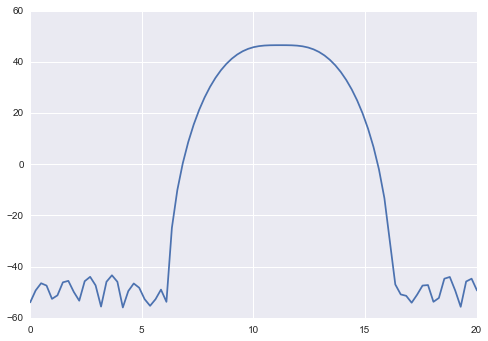

In [26]:
n = 4096
w = np.fft.rfft(s * get_window('blackmanharris', m), n=n)
freqs = np.fft.rfftfreq(n, d=t[1] - t[0])
plt.plot(freqs, 20*np.log10(np.abs(w)))
plt.ylim(-60, 60)
plt.xlim(0, 20)

The previous plot doesn't allow us to identify the two spectral peaks present in the original signal. This is expected, because we used a window with a very large mainlobe. What about using a window with a narrow mainlobe, like the boxcar window?

(0, 20)

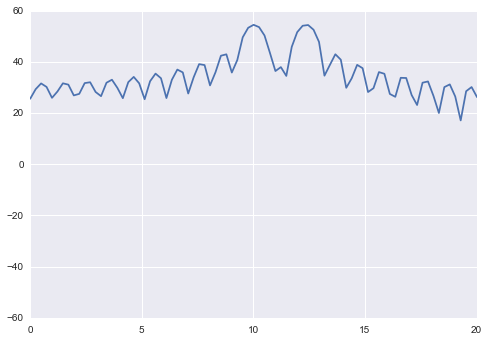

In [27]:
w = np.fft.rfft(s * get_window('boxcar', m), n=n)
freqs = np.fft.rfftfreq(n, d=t[1] - t[0])
plt.plot(freqs, 20*np.log10(np.abs(w)))
plt.ylim(-60, 60)
plt.xlim(0, 20)

In this case, we can clearly see our two peaks, at the expense of very high sidelobes. These sidelobes can hide other peaks, as we will see in the next example.

## Two sinusoids with different amplitudes 

Let's generate our sample data: two sinusoids with different frequencies and different amplitudes. One of them will have a low amplitude.

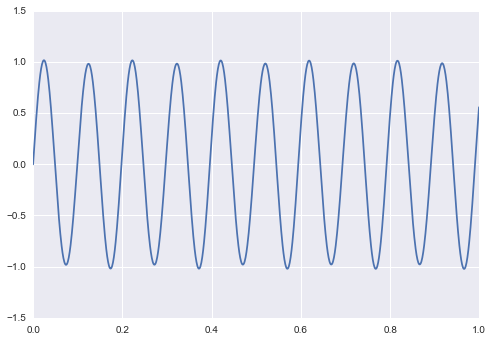

In [28]:
t = np.arange(0, 1, step=1/1000.)
s = np.sin(2 * np.pi * 10.1 * t) + 0.025 * np.sin(2 * np.pi * 15.2 * t)
plt.plot(t, s)

We can barely see the second sinusoid in the time domain plot. What about in the frequency domain?

(0, 20)

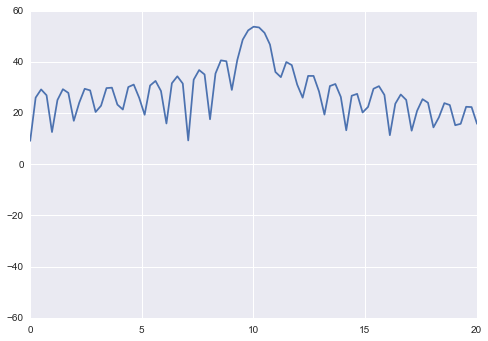

In [29]:
n = 4096
w = np.fft.rfft(s * get_window('boxcar', m), n=n)
freqs = np.fft.rfftfreq(n, d=t[1] - t[0])
plt.plot(freqs, 20*np.log10(np.abs(w)))
plt.ylim(-60, 60)
plt.xlim(0, 20)

The boxcar window sidelobes hide the second sinusoid at the 15 Hz frequency. Using a blackman window, we can make it appear!

(0, 20)

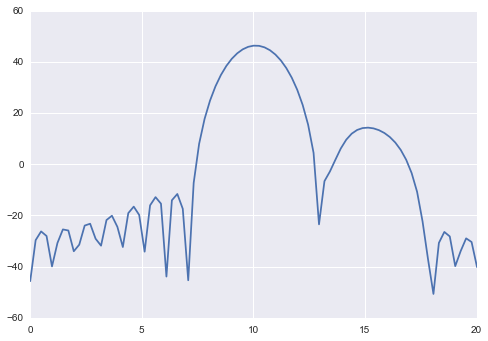

In [30]:
n = 4096
w = np.fft.rfft(s * get_window('blackman', m), n=n)
freqs = np.fft.rfftfreq(n, d=t[1] - t[0])
plt.plot(freqs, 20*np.log10(np.abs(w)))
plt.ylim(-60, 60)
plt.xlim(0, 20)

So again, it's all about making compromises. 

# Conclusions 

We've reached the end of this blog post. I think there are a couple of nice takeaways from this exploration:

- I realized that digital signal processing is far from easy. Even doing "just a basic Fourier transform" actually implicitly makes you use a boxcar window. This might or might not be a good thing depending on what you do. 
- The mainlobe / sidelobe plots I produced above can be used as references for practical applications. In particular mainlobe sizing is a great thing to do when working with your own data.
- There's no one-size-fits-all best choice for digital signal processing windowed data. Carefully explore the different options you have before jumping to conclusions.

I hope you've enjoyed this post. I've you like this topic and music in general, I highly recommend [Xavier Serra's class on Coursera](https://www.coursera.org/course/audio).

This post was entirely written using the IPython notebook. Its content is BSD-licensed. You can see a static view or download this notebook with the help of nbviewer at [20151028_FilteringWindowProperties.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20151028_FilteringWindowProperties.ipynb).